In [1]:
import matplotlib.pyplot as plt
import scanpy
import numpy as np
from dataset_lib import get_samples, get_scaler, get_mask_anndata
from classification_lib import DistributionDiscretizer, get_binary_mutual_info, get_binary_logdiff, NaiveClassifier

## Loading the annotated data

In [2]:
adata_file = 'adata_example.h5ad'
annotated_data = scanpy.read_h5ad(adata_file)
scaler = get_scaler(annotated_data, nsamples=2000)

## Rating the genes based on differential expression
Here we look at three metrics: Log expression (logdiff), Earth mover's distance (EMD), and Mutual information (MI)
All of the genes are evaluated based on their differential expression between untreated cells and cells after 3 hours of being exposed to candida albicans (CA).

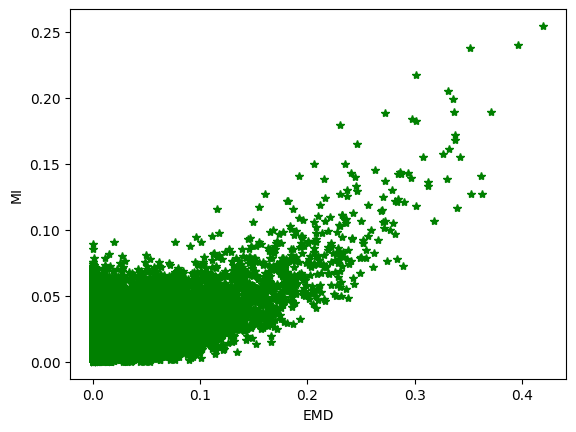

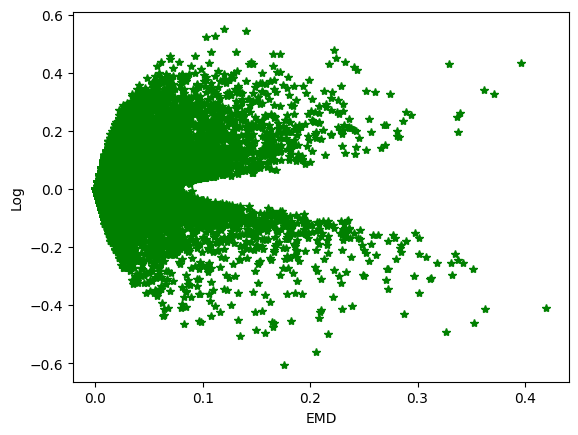

In [3]:
tp0 = ['UT']
tp1 = ['3hCA']

celltype = 'monocyte'

filt0 = {'timepoint': tp0, 'celltype': celltype}
filt1 = {'timepoint': tp1, 'celltype': celltype}

annotated_data_class0 = annotated_data[get_mask_anndata(annotated_data, filt0)]
annotated_data_class1 = annotated_data[get_mask_anndata(annotated_data, filt1)]

distrib = DistributionDiscretizer(nbins=10, tolerance=0.0, double_sided=True)
iterations = 10
nsamples = 50

emd_list = []
logdiff_list = []
mi_list = []

logdiff_epsilon = 0.01
for it in range(iterations):
    samples_cl0 = get_samples(annotated_data_class0, nsamples=nsamples, scaler=scaler, replacement=True)
    samples_cl1 = get_samples(annotated_data_class1, nsamples=nsamples, scaler=scaler, replacement=True)

    logdiff_list.append(get_binary_logdiff(samples_cl0, samples_cl1, epsilon=logdiff_epsilon))
    emd_list.append(distrib.calc_emd(samples_cl0, samples_cl1))
    mi_list.append(get_binary_mutual_info(samples_cl0, samples_cl1))


logdiff = np.array(logdiff_list)
emd = np.array(emd_list)
mi = np.array(mi_list)

plt.plot(emd.mean(axis=0), mi.mean(axis=0), 'g*')
plt.xlabel('EMD')
plt.ylabel('MI')
plt.figure()
plt.plot(emd.mean(axis=0), logdiff.mean(axis=0), 'g*')
plt.xlabel('EMD')
plt.ylabel('Log')
plt.show()

## Naive Bayes classification

In [10]:
tp0 = ['UT']
tp1 = ['3hCA', '24hCA']

# Naming the labels for each class
l0 = 'UT'
l1 = 'T'

celltype = 'monocyte'

filt0 = {'timepoint': tp0, 'celltype': celltype}
filt1 = {'timepoint': tp1, 'celltype': celltype}

annotated_data_class0 = annotated_data[get_mask_anndata(annotated_data, filt0)]
annotated_data_class1 = annotated_data[get_mask_anndata(annotated_data, filt1)]

classifier = NaiveClassifier(distrib_func=DistributionDiscretizer(nbins=10, tolerance=0.05))
n_iterations = 10

n_genes = 10

# getting the genes with the highest differential expression
genes = emd.mean(axis=0).argpartition(-n_genes)[-n_genes:]
sub_samples0 = get_samples(annotated_data_class0, 100, scaler=scaler)
sub_samples1 = get_samples(annotated_data_class1, 100, scaler=scaler)
classifier.fit({l0: sub_samples0[:, genes], l1: sub_samples1[:, genes]})

test_sub_samples0 = get_samples(annotated_data_class0, 100, scaler=scaler)
test_sub_samples1 = get_samples(annotated_data_class1, 100, scaler=scaler)

cf0 = classifier.classify(test_sub_samples0[:, genes])
cf1 = classifier.classify(test_sub_samples1[:, genes])

accuracy0 = (np.sum(cf0 == l0) / len(cf0))
accuracy1 = (np.sum(cf1 == l1) / len(cf1))

print('Class 0 cells correctly classified (rate) :', accuracy0)
print('Class 1 cells correctly classified (rate) :', accuracy1)

Class 0 cells correctly classified (rate) : 0.84
Class 1 cells correctly classified (rate) : 0.83


## Plotting PCA projection of cells 
Green are red points represent correctly classified and mis-classified cells respectively. Star points correspond to cells from class 0 (i.e. untreated) and circle points correspond to class 1 (i.e. treated)

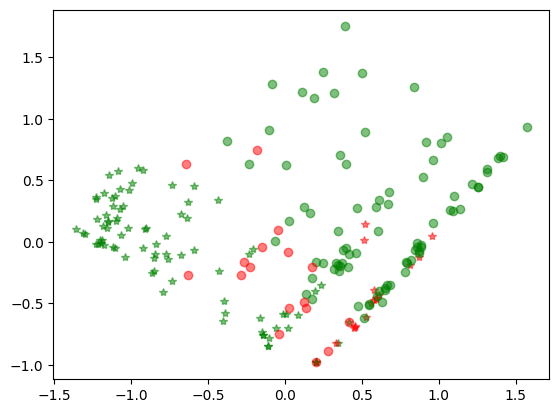

In [16]:
from sklearn.decomposition import PCA
tot_data = np.concatenate((test_sub_samples0[:, genes], test_sub_samples1[:, genes]), axis=0)
pca = PCA(n_components=2)
pca.fit(tot_data)
transformed0 = pca.transform(test_sub_samples0[:, genes])
plt.plot(transformed0[cf0 == l0, 0], transformed0[cf0 == l0, 1], 'g*', alpha=0.5)
plt.plot(transformed0[cf0 != l0, 0], transformed0[cf0 != l0, 1], 'r*', alpha=0.5)

transformed1 = pca.transform(test_sub_samples1[:, genes])
plt.plot(transformed1[cf1 == l1, 0], transformed1[cf1 == l1, 1], 'go', alpha=0.5)
plt.plot(transformed1[cf1 != l1, 0], transformed1[cf1 != l1, 1], 'ro', alpha=0.5)
plt.show()